# Verify data collection methods and code in general

# Data Scrape

['assists', 'attempted_passes', 'big_chances_created', 'big_chances_missed', 'bonus', 'bps', 'clean_sheets', 'clearances_blocks_interceptions', 'completed_passes', 'creativity', 'dribbles', 'ea_index', 'element', 'errors_leading_to_goal', 'errors_leading_to_goal_attempt', 'fixture', 'fouls', 'goals_conceded', 'goals_scored', 'ict_index', 'id', 'influence', 'key_passes', 'kickoff_time', 'kickoff_time_formatted', 'loaned_in', 'loaned_out', 'minutes', 'offside', 'open_play_crosses', 'opponent_team', 'own_goals', 'penalties_conceded', 'penalties_missed', 'penalties_saved', 'recoveries', 'red_cards', 'round', 'saves', 'selected', 'tackled', 'tackles', 'target_missed', 'team_a_score', 'team_h_score', 'threat', 'total_points', 'transfers_balance', 'transfers_in', 'transfers_out', 'value', 'was_home', 'winning_goals', 'yellow_cards']

['assists', 'bonus', 'bps', 'clean_sheets', 'creativity', 'ea_index', 'element_code', 'end_cost', 'goals_conceded', 'goals_scored', 'ict_index', 'id', 'influence

In [209]:
import numpy as np
import pandas as pd
import glob
path = 'data/2016-17/players'
filenames = glob.glob(path + "/*/gw.csv")
all_p_gwData = (pd.read_csv(f) for f in filenames)
player_gw_1617 = pd.concat(all_p_gwData, keys=[i for i in range(683)])
player_gw_1617[:35]


assists  attempted_passes  big_chances_created  big_chances_missed  \
0 0         0                 7                    0                   0   
  1         0                30                    0                   0   
  2         0                24                    0                   0   
  3         0                31                    0                   0   
  4         0                23                    0                   0   
  5         0                36                    0                   0   
  6         0                16                    0                   0   
  7         0                21                    0                   0   
  8         0                47                    0                   1   
  9         0                14                    0                   0   
  10        0                35                    0                   0   
  11        0                19                    0                   0   
  12        0                33                    0                   0   
  13        0                43                    0                   0   
  14        0                39                    0                   0   
  15        0                 0                    0                   0   
  16        0                39                    0                   0   
  17        0                37                    0                   0   
  18        0                15                    0                   0   
  19        0                46                    0                   0   
  20        0                 2                    0                   0   
  21        0                 0                    0                   0   
  22        0                 0                    0                   0   
  23        0                22                    0                   0   
  24        0                35                    0                   0   
  25        0                45                    0                   0   
  26        0                33                    0                   0   
  27        1                30                    0                   0   
  28        0                37                    0                   0   
  29        0                26                    0                   0   
  30        0                38                    0                   0   
  31        0                26                    0                   0   
  32        0                52                    0                   0   
  33        0                47                    0                   0   
  34        0                49                    0                   0   

      bonus  bps  clean_sheets  clearances_blocks_interceptions  \
0 0       0    3             0                                1   
  1       0   12             0                                5   
  2       0   24             1                                2   
  3       0    9             0                                3   
  4       0    5             0                                2   
  5       0    5             0                                8   
  6       0    3             1                                4   
  7       0    9             0                                1   
  8       0    3             0                                2   
  9       0    1             0                                4   
  10      0    6             0                                3   
  11      1   28             0                                6   
  12      0    7             0                                1   
  13      0   12             0                                4   
  14      0    3             1                                2   
  15      0    0             0                                0   
  16      0    9             0                                2   
  17      0    5             1                                2

In [606]:
path = 'data/2016-17/players'
filenames = glob.glob(path + "/*/history.csv")
all_p_hData = (pd.read_csv(f, encoding='utf-8') for f in filenames)

player_history = pd.concat(all_p_hData, keys=[unicodedata.normalize('NFD', unicode(f[21:-12], "utf-8")).encode('ascii', 'ignore') for f in filenames])
#print player_history[:50]
player_data_df = player_history['total_points']


In [607]:
#print player_data_df

player_1617 = {} 
player_1718 = {}

for i, j in player_data_df.groupby(level = 0):
    mean_1718 = j[:].mean()
    mean_1617 = 0
    if len(j) > 1:
        mean_1617 = (j[:].sum() - j[len(j)-1])/float(len(j)-1)
        
    player_1617[i] = mean_1617
    player_1718[i] = mean_1718

    
player_1617_history_df = pd.DataFrame.from_dict(player_1617, orient='index', dtype=float)
player_1718_history_df = pd.DataFrame.from_dict(player_1718, orient='index', dtype=float)
#print player_1718_history_df

In [4]:
mat = np.zeros((683,9))
for i in range(683):
    mat[i][0] = p_hData[i]['assists']
    mat[i][1] = p_hData[i]['goals_scored']
    mat[i][2] = p_hData[i]['bonus']
    mat[i][3] = p_hData[i]['clean_sheets']
    mat[i][4] = p_hData[i]['creativity']
    mat[i][5] = p_hData[i]['saves']
    mat[i][6] = p_hData[i]['influence']
    mat[i][7] = p_hData[i]['start_cost']
    mat[i][8] = 0 if p_hData[i]['minutes'] == 0 else p_hData[i]['total_points'] / p_hData[i]['minutes']

In [5]:
from sklearn import linear_model
regr = linear_model.LinearRegression(normalize=True)
regr.fit(mat[:,0:7], mat[:,8])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=True)

In [6]:
print regr.coef_
print regr.intercept_

[  1.86498515e-03   1.84792236e-03   1.90717954e-04  -2.31108928e-03
  -4.91922858e-06   5.62941097e-05  -2.76038775e-06]
0.0483264326558


# Player Position Data embed

In [8]:
player_id = pd.read_csv('data/2016-17/player_idlist.csv')
player_pos = pd.read_csv('data/2016-17_pos_clean.csv')
n = 0
m = 0
for i in player_id.index:
    fname = player_id['first_name'][i]
    sname = player_id['second_name'][i]
    pname = fname + ' ' + sname
    n += 1
    for j in player_pos.index:
        if player_pos['player'][j] == pname:
#             print pname, player_pos['position'][j]
            m += 1
            player_id.loc[i, 'position'] = player_pos['position'][j]
# print n, m
player_id.to_csv('2016-17_player_position.csv')

In [9]:
player_id = pd.read_csv('data/2017-18/player_idlist.csv')
player_pos = pd.read_csv('data/2017-18_pos_clean.csv')
n = 0
m = 0
for i in player_id.index:
    fname = player_id['first_name'][i]
    sname = player_id['second_name'][i]
    pname = fname + ' ' + sname
    n += 1
    for j in player_pos.index:
        if player_pos['player'][j] == pname:
#             print pname, player_pos['position'][j]
            m += 1
            player_id.loc[i, 'position'] = player_pos['position'][j]
# print n, m
player_id.to_csv('2017-18_player_position.csv')

# Match Result field addition

In [10]:
path = 'data/2016-17/players'
filenames = glob.glob(path + "/*/gw.csv")
for f in filenames:
    a = pd.read_csv(f)
    b = a['team_h_score'] - a['team_a_score']
    for i in a.index:
        if a.loc[i, 'was_home'] == True:
            if b[i] < 0:
                a.loc[i, 'match_result'] = -1
            elif b[i] == 0:
                a.loc[i, 'match_result'] = 0
            else:
                a.loc[i, 'match_result'] = 1
        else:
            if b[i] < 0:
                a.loc[i, 'match_result'] = 1
            elif b[i] == 0:
                a.loc[i, 'match_result'] = 0
            else:
                a.loc[i, 'match_result'] = -1
    a.to_csv(f[:-4] + "_match_result.csv")

# Training and Prediction

In [48]:
from sklearn.ensemble import RandomForestRegressor
regr = RandomForestRegressor(max_depth=2, random_state=0)
regr.fit(x, y)

path = 'data/2016-17/players/'
player_score = {}
for i in player_avg_history.index:
#     print i
    f = unicode(path + i + '/gw.csv', "utf-8")
    a = pd.read_csv(f)
    a = a[a['minutes']>0]
    b = a[trainFeature][-5:]
#     print b
    c = regr.predict(b).mean() if b.shape[0] > 0 else 0
#     print c
    player_score[i] = c

sorted_x = sorted(player_score.items(), key=operator.itemgetter(1), reverse=True)
sorted_x[:10]

[('Christian_Fuchs', 4.9670230237886175),
 ('Jan_Vertonghen', 4.9670230237886175),
 ('Oumar_Niasse', 4.9670230237886175),
 ('Cesc_F\xc3\xa0bregas', 4.9670230237886175),
 ('Ahmed_Musa', 4.9670230237886175),
 ('Antonio_Valencia', 4.9670230237886175),
 ('Chris_Brunt', 4.9670230237886175),
 ('Giannelli_Imbula', 4.9670230237886175),
 ('Jesse_Lingard', 4.9670230237886175),
 ('Peter_Crouch', 4.9670230237886175)]

# Calulating Evaluation Metric

Game week wise top scorers

In [189]:
path = 'data/2017-18/players'
filenames = glob.glob(path + "/*/gw.csv")
all_p_gwData = (pd.read_csv(f, index_col = 'round', usecols = ['round', 'total_points']) for f in filenames)
players_gw = pd.concat(all_p_gwData, keys=[f[21:-7] for f in filenames])

for i,j in players_gw.groupby(level=1):
#     print j.idxmax(axis=0).values, j.max(axis=0).values
    print j.sort_values(by=['total_points'], ascending=False)[:10]

                             total_points
                      round              
Ahmed El-Sayed_Hegazi 1                15
Ben_Davies            1                14
Romelu_Lukaku         1                13
Sam_Vokes             1                13
Jamie_Vardy           1                13
Christian_Eriksen     1                12
Roberto_Firmino       1                12
Steve_Mounie          1                12
Mohamed_Salah         1                11
Henrikh_Mkhitaryan    1                11
                                 total_points
                          round              
Marcos_Alonso             2                16
Eric_Bailly               2                15
Harry_Maguire             2                15
Paul_Pogba                2                15
Javier_Hern�ndez Balc�zar 2                13
Jack_Butland              2                11
Richarlison_de Andrade    2                11
Riyad_Mahrez              2                11
Henrikh_Mkhitaryan        2         

# NEW


In [506]:
import unicodedata
import pandas as pd
import glob



In [705]:
path = 'data/2016-17/players'
filenames = glob.glob(path + "/*/history.csv")
all_p_hData = (pd.read_csv(f, encoding='utf-8') for f in filenames)

player_history = pd.concat(all_p_hData, keys=[unicodedata.normalize('NFD', unicode(f[21:-12], "utf-8")).encode('ascii', 'ignore') for f in filenames])
#print player_history[:50]
player_data_df = player_history['total_points']


#print player_data_df

player_1617 = {} 
player_1718 = {}

for i, j in player_data_df.groupby(level = 0):
    mean_1718 = j[:].mean()
    mean_1617 = 0
    if len(j) > 1:
        mean_1617 = (j[:].sum() - j[len(j)-1])/float(len(j)-1)
        
    player_1617[i] = mean_1617
    player_1718[i] = mean_1718

    
player_1617_history_df = pd.DataFrame.from_dict(player_1617, orient='index', dtype=float)
player_1718_history_df = pd.DataFrame.from_dict(player_1718, orient='index', dtype=float)
#print player_1718_history_df

In [706]:
path = 'data/2016-17/players'
filenames = glob.glob(path + "/*/gw.csv")

all_p_gwData = (pd.read_csv(f, index_col='round', encoding='utf-8') for f in filenames)
players_gw_1617_df = pd.concat(all_p_gwData, keys=[unicodedata.normalize('NFD', unicode(f[21:-7], "utf-8")).encode('ascii', 'ignore') for f in filenames])

#players_gw_1617_df


In [707]:
path = 'data/Player_Pos_Team_2016-17.csv'
pname_pos_team_1617_df = pd.read_csv(path, skiprows=None, encoding='utf-8')

fname1 = [unicodedata.normalize('NFD', x).encode('ascii', 'ignore') for x in pname_pos_team_1617_df['FirstName']]
sname1 = [unicodedata.normalize('NFD', x).encode('ascii', 'ignore') for x in pname_pos_team_1617_df['Surname']]
fname = pd.DataFrame({'name':fname1})
sname = pd.DataFrame({'name':sname1})

pname = fname + '_' + sname
pname_pos_team_1617_df['P_name'] = pname

player_pos_team = pname_pos_team_1617_df[['PositionsList', 'Team', 'P_name']].copy()
player_pos_team.set_index('P_name', inplace=True)
player_pos_team[:5]

,PositionsList,Team
P_name,,
Almen_Abdi,MID,Watford
Charlie_Adam,MID,Stoke
Albert_Adomah,MID,Middlesbrough
Adrian_San Miguel del Castillo,GLK,West Ham
Ibrahim_Afellay,MID,Stoke


In [708]:
count = 0
for i,j in players_gw_1617_df.groupby(level=0):
    if i in player_pos_team.index:
        players_gw_1617_df.loc[i, 'position'] = player_pos_team.loc[i]['PositionsList']
        players_gw_1617_df.loc[i, 'team'] = player_pos_team.loc[i]['Team']    
        count += 1
    else:
        print i

print count



Alex_Pike
Andrea_Ranocchia
Angel_Gomes
Daniel_Drinkwater
Elliot_Embleton
Emilio_Nsue Lopez
Gerhard_Tremmel
Giedrius_Arlauskis
Joleon_Lescott
Joshua_Harrop
Kamil_Grosicki
Mateusz_Hewelt
Matthew_Willock
Omar_Elabdellaoui
Rene_Gilmartin
668


In [709]:
team_ids_df = pd.read_csv('data/2016-17_Team_IDs.txt', index_col='ID')
print team_ids_df.loc[1]


Team    Arsenal
Name: 1, dtype: object


In [710]:
for i in team_ids_df.index:
    team_name = team_ids_df.loc[i,'Team']
    players_gw_1617_df['opponent_team'].replace(to_replace=i, value=team_name, inplace=True)

players_gw_1617_df['opponent_team']

                     round
Jeff_Hendrick        4                  Hull
                     5             Leicester
                     6               Watford
                     7               Arsenal
                     8           Southampton
                     9               Everton
                     10              Man Utd
                     11       Crystal Palace
                     12            West Brom
                     13             Man City
                     14                Stoke
                     15          Bournemouth
                     16             West Ham
                     17            Tottenham
                     18        Middlesbrough
                     19           Sunderland
                     20             Man City
                     21          Southampton
                     22              Arsenal
                     23            Leicester
                     24              Watford
                     25     

In [711]:
print players_gw_1617_df.loc['Charlie_Adam']

       assists  attempted_passes  big_chances_created  big_chances_missed  \
round                                                                       
1            0                 0                    0                   0   
2            0                 0                    0                   0   
3            0                 0                    0                   0   
4            0                 9                    0                   0   
5            0                 0                    0                   0   
6            0                 1                    0                   0   
7            0                 0                    0                   0   
8            0                15                    0                   0   
9            0                 0                    0                   0   
10           0                46                    0                   0   
11           0                51                    0                   0   

In [712]:
path = 'data/2017-18/players'
filenames = glob.glob(path + "/*/gw.csv")

all_p_gwData = (pd.read_csv(f, index_col='round', encoding='utf-8') for f in filenames)
players_gw_1718_df = pd.concat(all_p_gwData, keys=[unicodedata.normalize('NFD', unicode(f[21:-7], "utf-8")).encode('ascii', 'ignore') for f in filenames])


for name,j in players_gw_1718_df.groupby(level=0):
    name = unicode(name, "utf-8")
    name = unicodedata.normalize('NFD', name).encode('ascii', 'ignore')

print players_gw_1718_df.loc['Aaron_Cresswell']

       assists  attempted_passes  big_chances_created  big_chances_missed  \
round                                                                       
1            0                10                    0                   0   
2            0                21                    0                   0   
3            0                43                    0                   0   
4            0                22                    1                   0   
5            0                30                    0                   0   
6            0                44                    0                   0   
7            0                40                    0                   0   
8            0                25                    0                   0   
9            0                 0                    0                   0   
10           1                17                    1                   0   
11           0                42                    0                   0   

In [713]:
path = 'data/Player_Pos_Team_2017-18.csv'
pname_pos_team_1718_df = pd.read_csv(path, skiprows=None, encoding='utf-8')

fname1 = [unicodedata.normalize('NFD', x).encode('ascii', 'ignore') for x in pname_pos_team_1718_df['FirstName']]
sname1 = [unicodedata.normalize('NFD', x).encode('ascii', 'ignore') for x in pname_pos_team_1718_df['Surname']]
fname = pd.DataFrame({'name':fname1})
sname = pd.DataFrame({'name':sname1})

pname = fname + '_' + sname
pname_pos_team_1718_df['P_name'] = pname

player_pos_team1 = pname_pos_team_1718_df[['PositionsList', 'Team', 'P_name']].copy()
player_pos_team1.set_index('P_name', inplace=True)
player_pos_team1[:5]

,PositionsList,Team
P_name,,
Rolando_Aarons,MID,Newcastle Utd
Tammy_Abraham,FWD,Swansea
Charlie_Adam,MID,Stoke
Adam_Smith,DEF,Bournemouth
Oluwatosin_Adarabioyo,DEF,Man City


In [714]:
count = 0
for i,j in players_gw_1718_df.groupby(level=0):
    if i in player_pos_team1.index:
        players_gw_1718_df.loc[i, 'position'] = player_pos_team1.loc[i,'PositionsList']
        players_gw_1718_df.loc[i, 'team'] = player_pos_team1.loc[i]['Team']
        count += 1
        
print count
print players_gw_1718_df.loc['Aaron_Cresswell']

583
       assists  attempted_passes  big_chances_created  big_chances_missed  \
round                                                                       
1            0                10                    0                   0   
2            0                21                    0                   0   
3            0                43                    0                   0   
4            0                22                    1                   0   
5            0                30                    0                   0   
6            0                44                    0                   0   
7            0                40                    0                   0   
8            0                25                    0                   0   
9            0                 0                    0                   0   
10           1                17                    1                   0   
11           0                42                    0                   

In [715]:
team_ids_df = pd.read_csv('data/2017-18_Team_IDs.txt', index_col='ID')
print team_ids_df.loc[1]

Team    Arsenal
Name: 1, dtype: object


In [716]:
for i in team_ids_df.index:
    team_name = team_ids_df.loc[i,'Team']
    players_gw_1718_df['opponent_team'].replace(to_replace=i, value=team_name, inplace=True)

players_gw_1718_df['opponent_team']

                    round
Jeff_Hendrick       1                       Chelsea
                    2                     West Brom
                    3                     Tottenham
                    4                Crystal Palace
                    5                     Liverpool
                    6             Huddersfield Town
                    7                       Everton
                    8                      West Ham
                    9                      Man City
                    10                Newcastle Utd
                    11                  Southampton
                    12                      Swansea
                    13                      Arsenal
                    14                  Bournemouth
                    15                    Leicester
                    16                      Watford
                    17                        Stoke
                    18       Brighton & Hove Albion
                    19                

In [717]:
general_feature_cols = ['was_home', 'opponent_team']

X_train_gen_features_df = players_gw_1617_df.loc[:, general_feature_cols]
print X_train_gen_features_df.shape

Y_train_gen_features_df = players_gw_1617_df.loc[:, ['total_points']]
print Y_train_gen_features_df.shape

(23679, 2)
(23679, 1)


# Create Train and Test Data

# TRAIN DATA

In [718]:
usecols = ['assists', 'attempted_passes', 'big_chances_created', 'big_chances_missed', 'bonus', 'bps', 'clean_sheets', 
'clearances_blocks_interceptions', 'completed_passes', 'creativity', 'dribbles', 'ea_index', 'errors_leading_to_goal', 'errors_leading_to_goal_attempt',
'fouls', 'goals_conceded', 'goals_scored', 'ict_index', 'influence', 'key_passes', 'minutes', 'offside', 'open_play_crosses', 
'own_goals', 'penalties_conceded', 'penalties_missed', 'penalties_saved', 'recoveries', 'red_cards', 'saves', 'selected', 'tackled', 
'tackles', 'target_missed', 'threat', 'transfers_balance', 'total_points', 'history_points', 'value', 'yellow_cards']

print players_gw_1617_df.columns

Index([                        u'assists',                u'attempted_passes',
                   u'big_chances_created',              u'big_chances_missed',
                                 u'bonus',                             u'bps',
                          u'clean_sheets', u'clearances_blocks_interceptions',
                      u'completed_passes',                      u'creativity',
                              u'dribbles',                        u'ea_index',
                               u'element',          u'errors_leading_to_goal',
        u'errors_leading_to_goal_attempt',                         u'fixture',
                                 u'fouls',                  u'goals_conceded',
                          u'goals_scored',                       u'ict_index',
                                    u'id',                       u'influence',
                            u'key_passes',                    u'kickoff_time',
                u'kickoff_time_formatted',          

In [719]:
players_gw_1617_df['history_points'] = 0



for i, j in players_gw_1617_df.groupby(level = 0):
    if i in player_1617_history_df.index:
        #print player_1617_history_df.loc[i,0]
        players_gw_1617_df.loc[i,'history_points'] = player_1617_history_df.loc[i,0]
        
print players_gw_1617_df.loc['Aaron_Cresswell', 'history_points']      
        

round
1     131.0
2     131.0
3     131.0
4     131.0
5     131.0
6     131.0
7     131.0
8     131.0
9     131.0
10    131.0
11    131.0
12    131.0
13    131.0
14    131.0
15    131.0
16    131.0
17    131.0
18    131.0
19    131.0
20    131.0
21    131.0
22    131.0
23    131.0
24    131.0
25    131.0
26    131.0
27    131.0
28    131.0
29    131.0
30    131.0
31    131.0
32    131.0
33    131.0
34    131.0
35    131.0
36    131.0
37    131.0
38    131.0
Name: history_points, dtype: float64


In [720]:
players_gw_1718_df['history_points'] = 0



for i, j in players_gw_1718_df.groupby(level = 0):
    if i in player_1718_history_df.index:
        #print player_1617_history_df.loc[i,0]
        players_gw_1718_df.loc[i,'history_points'] = player_1718_history_df.loc[i,0]
        
print players_gw_1718_df.loc['Aaron_Cresswell', 'history_points']      

round
1     107.333333
2     107.333333
3     107.333333
4     107.333333
5     107.333333
6     107.333333
7     107.333333
8     107.333333
9     107.333333
10    107.333333
11    107.333333
12    107.333333
13    107.333333
14    107.333333
15    107.333333
16    107.333333
17    107.333333
18    107.333333
19    107.333333
Name: history_points, dtype: float64


In [721]:
X_train_players_glk_gw_df = players_gw_1617_df.loc[players_gw_1617_df['position'] == 'GLK']
X_train_players_def_gw_df = players_gw_1617_df.loc[players_gw_1617_df['position'] == 'DEF']
X_train_players_mid_gw_df = players_gw_1617_df.loc[players_gw_1617_df['position'] == 'MID']
X_train_players_fwd_gw_df = players_gw_1617_df.loc[players_gw_1617_df['position'] == 'FWD']

In [722]:
X_train_players_glk_avg_df = X_train_players_glk_gw_df[usecols].groupby(level=0).mean()
X_train_players_def_avg_df = X_train_players_def_gw_df[usecols].groupby(level=0).mean()
X_train_players_mid_avg_df = X_train_players_mid_gw_df[usecols].groupby(level=0).mean()
X_train_players_fwd_avg_df = X_train_players_fwd_gw_df[usecols].groupby(level=0).mean()

In [723]:
n = 0
for i in X_train_players_def_avg_df.index:
    if i in player_pos_team.index:
        n += 1
        X_train_players_def_avg_df.loc[i, 'team'] = player_pos_team.loc[i]['Team']
print n

n = 0
for i in X_train_players_fwd_avg_df.index:
    if i in player_pos_team.index:
        n += 1
        X_train_players_fwd_avg_df.loc[i, 'team'] = player_pos_team.loc[i]['Team']
print n

n = 0
for i in X_train_players_glk_avg_df.index:
    if i in player_pos_team.index:
        n += 1
        X_train_players_glk_avg_df.loc[i, 'team'] = player_pos_team.loc[i]['Team']
print n

n = 0
for i in X_train_players_mid_avg_df.index:
    if i in player_pos_team.index:
        n += 1
        X_train_players_mid_avg_df.loc[i, 'team'] = player_pos_team.loc[i]['Team']
print n

210
110
69
279


In [724]:
Y_train_players_fwd_avg_df = X_train_players_fwd_avg_df.loc[:, X_train_players_fwd_avg_df.columns == 'total_points']
Y_train_players_def_avg_df = X_train_players_def_avg_df.loc[:, X_train_players_def_avg_df.columns == 'total_points']
Y_train_players_mid_avg_df = X_train_players_mid_avg_df.loc[:, X_train_players_mid_avg_df.columns == 'total_points']
Y_train_players_glk_avg_df = X_train_players_glk_avg_df.loc[:, X_train_players_glk_avg_df.columns == 'total_points']

X_train_players_fwd_avg_df = X_train_players_fwd_avg_df.loc[:, X_train_players_fwd_avg_df.columns != 'total_points']
X_train_players_def_avg_df = X_train_players_def_avg_df.loc[:, X_train_players_def_avg_df.columns != 'total_points']
X_train_players_mid_avg_df = X_train_players_mid_avg_df.loc[:, X_train_players_mid_avg_df.columns != 'total_points']
X_train_players_glk_avg_df = X_train_players_glk_avg_df.loc[:, X_train_players_glk_avg_df.columns != 'total_points']

# TEST DATA

In [725]:
usecols = ['assists', 'attempted_passes', 'big_chances_created', 'big_chances_missed', 'bonus', 'bps', 'clean_sheets', 
'clearances_blocks_interceptions', 'completed_passes', 'creativity', 'dribbles', 'ea_index', 'errors_leading_to_goal', 'errors_leading_to_goal_attempt',
'fouls', 'goals_conceded', 'goals_scored', 'ict_index', 'influence', 'key_passes', 'minutes', 'offside', 'open_play_crosses', 
'own_goals', 'penalties_conceded', 'penalties_missed', 'penalties_saved', 'recoveries', 'red_cards', 'saves', 'selected', 'tackled', 
'tackles', 'target_missed', 'threat', 'transfers_balance', 'total_points', 'history_points', 'value', 'yellow_cards']

print players_gw_1718_df.columns



X_test_df = players_gw_1718_df.copy()
# count = 0
for i,j in X_test_df.groupby(level=0):
    gw_list = [x[1] for x in list(j.index)]
    for gw, row in j.iterrows():
        X_test_df.loc[(gw[0], gw[1]), usecols] = 0.0
        if(gw[1] > 5):
#             if(count > 1):
#                 break
            if((gw[1]-1) in gw_list):
                X_test_df.loc[(gw[0], gw[1]), usecols] += (players_gw_1718_df.loc[(gw[0], gw[1]-1), usecols])
            if((gw[1]-2) in gw_list):
                X_test_df.loc[(gw[0], gw[1]), usecols] += (players_gw_1718_df.loc[(gw[0], gw[1]-2), usecols])
            if((gw[1]-3) in gw_list):
                X_test_df.loc[(gw[0], gw[1]),usecols] += (players_gw_1718_df.loc[(gw[0], gw[1]-3), usecols])
            if((gw[1]-4) in gw_list):
                X_test_df.loc[(gw[0], gw[1]), usecols] += (players_gw_1718_df.loc[(gw[0], gw[1]-4), usecols])
            if((gw[1]-5) in gw_list):
                X_test_df.loc[(gw[0], gw[1]), usecols] += (players_gw_1718_df.loc[(gw[0], gw[1]-5), usecols])
            #print X_test_df.loc[gw, usecols]
            X_test_df.loc[gw,usecols] = X_test_df.loc[gw,usecols].div(5, axis=0)
            #X_test_df.loc[gw] = X_test_df/5
            #print X_test_df.loc[gw]
            
            #count += 1
        #print j.loc[(gw[0], gw[1])]
#     if count > 1:
#         break

#print players_gw_1718_df.iloc[:, players_gw_1718_df.groupby(level == 0) == 'Aaron_Cresswell']
# print players_gw_1718_df.loc[('Aaron_Cresswell',20)]

Index([                        u'assists',                u'attempted_passes',
                   u'big_chances_created',              u'big_chances_missed',
                                 u'bonus',                             u'bps',
                          u'clean_sheets', u'clearances_blocks_interceptions',
                      u'completed_passes',                      u'creativity',
                              u'dribbles',                        u'ea_index',
                               u'element',          u'errors_leading_to_goal',
        u'errors_leading_to_goal_attempt',                         u'fixture',
                                 u'fouls',                  u'goals_conceded',
                          u'goals_scored',                       u'ict_index',
                                    u'id',                       u'influence',
                            u'key_passes',                    u'kickoff_time',
                u'kickoff_time_formatted',          

In [726]:
%store X_test_df

Stored 'X_test_df' (DataFrame)


In [727]:
%store -r

In [728]:
usecols.extend(['position', 'team'])
X_test_df_temp = X_test_df[usecols]

X_test_players_glk_gw_df = X_test_df_temp.loc[X_test_df_temp['position'] == 'GLK']
X_test_players_def_gw_df = X_test_df_temp.loc[X_test_df_temp['position'] == 'DEF']
X_test_players_mid_gw_df = X_test_df_temp.loc[X_test_df_temp['position'] == 'MID']
X_test_players_fwd_gw_df = X_test_df_temp.loc[X_test_df_temp['position'] == 'FWD']

print X_test_players_fwd_gw_df.shape
print X_test_players_def_gw_df.shape
print X_test_players_glk_gw_df.shape
print X_test_players_mid_gw_df.shape

(1463, 42)
(3530, 42)
(1124, 42)
(4446, 42)


In [729]:
Y_test_players_fwd_gw_df = players_gw_1718_df.loc[players_gw_1718_df['position'] == 'FWD']
Y_test_players_fwd_gw_df = Y_test_players_fwd_gw_df.loc[:, Y_test_players_fwd_gw_df.columns == 'total_points']

In [660]:
Y_test_players_fwd_gw_df

total_points
                          round              
Diego_Da Silva Costa      1                 0
                          2                 0
                          3                 0
                          4                 0
                          5                 0
                          6                 0
                          7                 0
                          8                 0
                          9                 0
                          10                0
                          11                0
                          12                0
                          13                0
                          14                0
                          15                0
                          16                0
                          17                0
                          18                0
                          19                0
Daniel_Sturridge          1                 0
                          2                 2
                          3                 5
                          4                 0
                          5                 2
                          6                 4
                          7                 2
                          8                 1
                          9                 1
                          10                6
                          11                0
...                                       ...
Javier_Hernandez Balcazar 9                 1
                          10                9
                          11                2
                          12                0
                          13                0
                          14                0
                          15                0
                          16                0
                          17                1
                          18                1
                          19                1
Ashley_Fletcher           1                 0
                          2                 0
                          3                 0
                          4                 0
                          5                 0
                          6                 0
                          7                 0
                          8                 0
                          9                 0
                          10                0
                          11                0
                          12                0
                          13                0
                          14                0
                          15                0
                          16                0
                          17                0
                          18                0
                          19                0

[1463 rows x 1 columns]

In [730]:
Y_test_players_def_gw_df = players_gw_1718_df.loc[players_gw_1718_df['position'] == 'DEF']
Y_test_players_def_gw_df = Y_test_players_def_gw_df.loc[:, Y_test_players_def_gw_df.columns == 'total_points']

Y_test_players_mid_gw_df = players_gw_1718_df.loc[players_gw_1718_df['position'] == 'MID']
Y_test_players_mid_gw_df = Y_test_players_mid_gw_df.loc[:, Y_test_players_mid_gw_df.columns == 'total_points']

Y_test_players_glk_gw_df = players_gw_1718_df.loc[players_gw_1718_df['position'] == 'GLK']
Y_test_players_glk_gw_df = Y_test_players_glk_gw_df.loc[:, Y_test_players_glk_gw_df.columns == 'total_points']

In [731]:
X_test_players_fwd_gw_df = X_test_players_fwd_gw_df.loc[:, X_test_players_fwd_gw_df.columns != 'total_points']
X_test_players_def_gw_df = X_test_players_def_gw_df.loc[:, X_test_players_def_gw_df.columns != 'total_points']
X_test_players_mid_gw_df = X_test_players_mid_gw_df.loc[:, X_test_players_mid_gw_df.columns != 'total_points']
X_test_players_glk_gw_df = X_test_players_glk_gw_df.loc[:, X_test_players_glk_gw_df.columns != 'total_points']

In [732]:
X_train_players_glk_avg_df.drop('team', axis=1, inplace=True)
#print X_train_players_glk_avg_df.columns

In [733]:
X_test_players_glk_gw_df.drop(['team', 'position'], axis=1, inplace=True)

In [734]:
print X_test_players_glk_gw_df.shape

(1124, 39)


# Training model and Prediction

In [735]:
X_train_players_def_avg_df.drop('team', axis=1, inplace=True)
X_test_players_def_gw_df.drop(['team', 'position'], axis=1, inplace=True)
X_train_players_fwd_avg_df.drop('team', axis=1, inplace=True)
X_test_players_fwd_gw_df.drop(['team', 'position'], axis=1, inplace=True)
X_train_players_mid_avg_df.drop('team', axis=1, inplace=True)
X_test_players_mid_gw_df.drop(['team', 'position'], axis=1, inplace=True)



# Training model definition:

In [803]:
from sklearn import linear_model
from sklearn.svm import SVR

def linear_regression(X_train_df, Y_train_df, X_test_df, Y_test_df, num=10):
    regr = linear_model.LinearRegression()
    regr.fit(X_train_df, Y_train_df)
    
    Y_pred_df = Y_test_df.copy()
    Y_pred_df['total_points'] = regr.predict(X_test_df)
    
    return calculate_precision(Y_test_df, Y_pred_df, num)




def svm_model(X_train_df, Y_train_df, X_test_df, Y_test_df, num=10):
    clf = SVR(C=1.0, epsilon=0.2)
    clf.fit(X_train_df, Y_train_df)

    Y_pred_df = Y_test_df.copy()
    Y_pred_df['total_points'] = clf.predict(X_test_df)
    
    return calculate_precision(Y_test_df, Y_pred_df, num)




def bayesian_ridge(X_train_df, Y_train_df, X_test_df, Y_test_df, num=10):
    clf2 = linear_model.BayesianRidge()
    clf2.fit(X_train_df, Y_train_df)
    
    Y_pred_df = Y_test_df.copy()
    Y_pred_df['total_points'] = clf2.predict(X_test_df)
    
    return calculate_precision(Y_test_df, Y_pred_df, num)




def neural_network(X_train_df, Y_train_df, X_test_df, Y_test_df, num=10):
    clf3 = neural_network.MLPRegressor(
    hidden_layer_sizes=(10,),  activation='relu', solver='adam', alpha=0.001, batch_size='auto',
    learning_rate='constant', learning_rate_init=0.01, power_t=0.5, max_iter=1000, shuffle=True,
    random_state=9, tol=0.0001, verbose=False, warm_start=False, momentum=0.9, nesterovs_momentum=True,
    early_stopping=False, validation_fraction=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    
    clf3.fit(X_train_df, Y_train_df)
    
    Y_pred_df = Y_test_df.copy()
    Y_pred_df['total_points'] = clf2.predict(X_test_df)
    
    return calculate_precision(Y_test_df, Y_pred_df, num)


In [804]:
import itertools
import numpy as np

from sklearn import svm, linear_model #, cross_validation


def transform_pairwise(X, y):
    X_new = []
    y_new = []
    y = np.asarray(y)
    if y.ndim == 1:
        y = np.c_[y, np.ones(y.shape[0])]
    comb = itertools.combinations(range(X.shape[0]), 2)
    comb_actual = []
    for k, (i, j) in enumerate(comb):
        # print(y[i], "   ", y[j])
        if y[i, 0] == y[j, 0]:
            # skip if same target or different group
            continue
        X_new.append(X[i] - X[j])
        y_new.append(np.sign(y[i, 0] - y[j, 0]))
        # output balanced classes
        if y_new[-1] != (-1) ** k:
            y_new[-1] = - y_new[-1]
            X_new[-1] = - X_new[-1]
        comb_actual.append([i,j])
    return np.asarray(X_new), np.asarray(y_new).ravel(), comb_actual


class RankSVM(svm.LinearSVC):
    """Performs pairwise ranking with an underlying LinearSVC model
    Input should be a n-class ranking problem, this object will convert it
    into a two-class classification problem, a setting known as
    `pairwise ranking`.
    See object :ref:`svm.LinearSVC` for a full description of parameters.
    """

    def fit(self, X, y):
        """
        Fit a pairwise ranking model.
        Parameters
        ----------
        X : array, shape (n_samples, n_features)
        y : array, shape (n_samples,) or (n_samples, 2)
        Returns
        -------
        self
        """
        X_trans, y_trans, comb = transform_pairwise(X, y)
        super(RankSVM, self).fit(X_trans, y_trans)
        return self

    def predict(self, X):
        """
        Predict an ordering on X. For a list of n samples, this method
        returns a list from 0 to n-1 with the relative order of the rows of X.
        Parameters
        ----------
        X : array, shape (n_samples, n_features)
        Returns
        -------
        ord : array, shape (n_samples,)
            Returns a list of integers representing the relative order of
            the rows in X.
        """
        if hasattr(self, 'coef_'):
            np.argsort(np.dot(X, self.coef_.T))
        else:
            raise ValueError("Must call fit() prior to predict()")

    def score(self, X, y):
        """
        Because we transformed into a pairwise problem, chance level is at 0.5
        """
        X_trans, y_trans, comb = transform_pairwise(X, y)
        return np.mean(super(RankSVM, self).predict(X_trans) == y_trans), super(RankSVM, self).predict(X_trans), y_trans, comb



In [811]:
import os

def apply_ranking_svm(X_train_df, Y_train_df, X_test_df, Y_test_df, num=10):
    X_train_temp = X_train_df.copy()
    X_test_temp = X_test_df.copy()

    X = X_train_temp.as_matrix()
    Y = np.array(Y_train_df)
    
    gw_prec_score = {}
    Y_pred_df = Y_test_df.copy()
    Y_pred_df['total_points'] = 0
    
    rank_svm = RankSVM().fit(X, Y)
    for j in range(6,20):
        Y_test = (Y_test_df.groupby(level=1)).get_group(j).as_matrix()
        X_test = (X_test_temp.groupby(level=1)).get_group(j).as_matrix()

        #print y

        score, y_pred, y_test, comb = rank_svm.score(X_test, Y_test)
        #print score

        Y_pred = (Y_pred_df.groupby(level=1)).get_group(j)
        Y_true_df = (Y_test_df.groupby(level=1)).get_group(j)
        #Y_pred['total_points'] = 0


        for counter, value in enumerate(comb):
            if y_pred[counter] == 1:
                Y_pred.iloc[value[0]]['total_points'] += 1
                #Y_pred_fwd.iloc[value[1]]['total_points'] -= 1
            else:
                #Y_pred_fwd.iloc[value[0]]['total_points'] -= 1
                Y_pred.iloc[value[1]]['total_points'] += 1

        gw_prec_score[j] = calculate_precision_one_gw(Y_true_df, Y_pred, num) 
        
    return gw_prec_score, Y_pred_df


In [806]:

def calculate_precision(y_true_df, y_pred_df, num=10):
    gw_prec_score = {}
    
    for j in range(6,20):
        
        y_true_gw_df = (y_true_df.groupby(level=1)).get_group(j)
        y_pred_gw_df = (y_pred_df.groupby(level=1)).get_group(j)
        
        score = calculate_precision_one_gw(y_true_gw_df, y_pred_gw_df, num)
        
#         y_true_group = (y_true_df.groupby(level=1)).get_group(j).sort_values(by=['total_points'], ascending=False)[:num]
#         y_pred_group = (y_pred_df.groupby(level=1)).get_group(j).sort_values(by=['total_points'], ascending=False)[:num]

#         y_true_list = []
#         for i in y_true_group.iterrows():
#             y_true_list.append([i[0][0]])

#         count = 0
#         for i in y_pred_group.iterrows():
#             if [i[0][0]] in y_true_list:
#                 count += 1

        gw_prec_score[j] = score

    return gw_prec_score


def calculate_precision_one_gw(Y_true_df, Y_pred_df, num=10):
    y_true_group = Y_true_df.sort_values(by=['total_points'], ascending=False)[:num]
    y_pred_group = Y_pred_df.sort_values(by=['total_points'], ascending=False)[:num]

    #print y_true_group
    #print y_pred_group
    
    y_true_list = []
    for i in y_true_group.iterrows():
        y_true_list.append([i[0][0]])

    count = 0
    for i in y_pred_group.iterrows():
        if [i[0][0]] in y_true_list:
            count += 1

    gw_prec_score = count/float(num)
    return gw_prec_score
    

# Test all models for all positions:

In [807]:
fwd_features = ['assists', 'big_chances_missed', 'dribbles', 'fouls', 'penalties_missed',
                'goals_scored', 'minutes', 'tackled', 
                'target_missed', 'value']

mid_features = ['assists', 'big_chances_created', 'completed_passes', 'dribbles', 'fouls', 
                'goals_scored', 'key_passes', 'minutes', 'open_play_crosses', 
                'tackled', 'value']

def_features = ['clean_sheets', 'clearances_blocks_interceptions',
               'errors_leading_to_goal',
               'fouls', 'goals_conceded', 'minutes', 'own_goals', 'tackles', 'value']

glk_features = ['clean_sheets',
               'fouls', 'goals_conceded', 'minutes', 'own_goals', 'penalties_conceded',
               'penalties_saved', 'saves', 'value']



fwd_implicit_features = ['bonus', 'bps', 'ict_index']
mid_implicit_features = ['bonus', 'ict_index']
def_implicit_features = ['bonus']
glk_implicit_features = ['bonus', 'bps', 'ict_index']

past_history_features = ['history_points']


print fwd_features
x_features = fwd_features + implicit_features
print x_features

['assists', 'big_chances_missed', 'dribbles', 'fouls', 'penalties_missed', 'goals_scored', 'minutes', 'tackled', 'target_missed', 'value']
['assists', 'big_chances_missed', 'dribbles', 'fouls', 'penalties_missed', 'goals_scored', 'minutes', 'tackled', 'target_missed', 'value', 'bonus', 'bps', 'ict_index']


In [808]:
from sklearn import preprocessing
normalizer = preprocessing.Normalizer()


def get_X_train_X_test_from_features_fwd(features):
    X_train_players_fwd_avg_temp_df = X_train_players_fwd_avg_df[features]
    X_test_players_fwd_gw_temp_df = X_test_players_fwd_gw_df[features]
    X_train_players_fwd_avg_norm_df = X_train_players_fwd_avg_temp_df.apply(lambda x: (x - x.min()) / (x.max() - x.min()))
    X_test_players_fwd_gw_norm_df = X_test_players_fwd_gw_temp_df.apply(lambda x: (x - x.min()) / (x.max() - x.min()))
    return X_train_players_fwd_avg_norm_df, X_test_players_fwd_gw_norm_df
    
    
def get_X_train_X_test_from_features_mid(features):
    X_train_players_mid_avg_temp_df = X_train_players_mid_avg_df[features]
    X_test_players_mid_gw_temp_df = X_test_players_mid_gw_df[features]
    X_train_players_mid_avg_norm_df = X_train_players_mid_avg_temp_df.apply(lambda x: (x - x.min()) / (x.max() - x.min()))
    X_test_players_mid_gw_norm_df = X_test_players_mid_gw_temp_df.apply(lambda x: (x - x.min()) / (x.max() - x.min()))
    return X_train_players_mid_avg_norm_df, X_test_players_mid_gw_norm_df



def get_X_train_X_test_from_features_def(features):
    X_train_players_def_avg_temp_df = X_train_players_def_avg_df[features]
    X_test_players_def_gw_temp_df = X_test_players_def_gw_df[features]
    X_train_players_def_avg_norm_df = X_train_players_def_avg_temp_df.apply(lambda x: (x - x.min()) / (x.max() - x.min()))
    X_test_players_def_gw_norm_df = X_test_players_def_gw_temp_df.apply(lambda x: (x - x.min()) / (x.max() - x.min()))
    return X_train_players_def_avg_norm_df, X_test_players_def_gw_norm_df
    
    
def get_X_train_X_test_from_features_glk(features):
    X_train_players_glk_avg_temp_df = X_train_players_glk_avg_df[features]
    X_test_players_glk_gw_temp_df = X_test_players_glk_gw_df[features]
    X_train_players_glk_avg_norm_df = X_train_players_glk_avg_temp_df.apply(lambda x: (x - x.min()) / (x.max() - x.min()))
    X_test_players_glk_gw_norm_df = X_test_players_glk_gw_temp_df.apply(lambda x: (x - x.min()) / (x.max() - x.min()))
    return X_train_players_glk_avg_norm_df, X_test_players_glk_gw_norm_df


In [742]:


# X_train_players_fwd_avg_norm_df = pd.DataFrame(normalizer.fit_transform(X_train_players_fwd_avg_df))
# X_train_players_mid_avg_norm_df = pd.DataFrame(normalizer.fit_transform(X_train_players_mid_avg_df))
# X_train_players_def_avg_norm_df = pd.DataFrame(normalizer.fit_transform(X_train_players_def_avg_df))
# X_train_players_glk_avg_norm_df = pd.DataFrame(normalizer.fit_transform(X_train_players_glk_avg_df))

# # X_test_pla
# X_test_players_fwd_gw_norm_df = pd.DataFrame(normalizer.fit_transform(X_test_players_fwd_gw_df))
# X_test_players_mid_gw_norm_df = pd.DataFrame(normalizer.fit_transform(X_test_players_mid_gw_df))
# X_test_players_def_gw_norm_df = pd.DataFrame(normalizer.fit_transform(X_test_players_def_gw_df))
# X_test_players_glk_gw_norm_df = pd.DataFrame(normalizer.fit_transform(X_test_players_glk_gw_df))



In [743]:
# Your code here
# from sklearn.feature_selection import SelectKBest
# from sklearn.feature_selection import chi2

# from sklearn.feature_selection import SelectKBest, f_regression
# select_k_best = SelectKBest(score_func=f_regression, k=5).fit_transform(X_train_players_fwd_avg_norm_df, Y_train_players_fwd_avg_df)

# mask = select_k_best.
# new_features = [] # The list of your K best features

# for bool, feature in zip(mask, feature_names):
#     if bool:
#         new_features.append(feature)

#Select K best using chi square
# sk = SelectKBest(chi2, k=10)
# sk.fit_transform(x, y)
# print "Most important features in distinguishing the 2 classes are: "
# print np.asarray(tf_vectorizer.get_feature_names())[sk.get_support()]
# print



# Forward position:

In [809]:

def get_forward_results(features):
    
    X_train, X_test = get_X_train_X_test_from_features_fwd(features)
    
    fwd_lin_precision = linear_regression(X_train, Y_train_players_fwd_avg_df, 
                                      X_test, Y_test_players_fwd_gw_df)
    #print "Linear regression: ", fwd_lin_precision

    fwd_svm_precision = svm_model(X_train, Y_train_players_fwd_avg_df, 
                                      X_test, Y_test_players_fwd_gw_df)
    #print "SVM: ", fwd_svm_precision

    fwd_bayesridge_precision = bayesian_ridge(X_train, Y_train_players_fwd_avg_df, 
                                      X_test, Y_test_players_fwd_gw_df)

    #print "Bayesian Ridge Regression: ", fwd_bayesridge_precision


    fwd_svm_rank_precision, Y_pred_df = apply_ranking_svm(X_train, Y_train_players_fwd_avg_df, 
                                      X_test, Y_test_players_fwd_gw_df)

    #print "Ranking SVM: ", fwd_svm_rank_precision
    
    return fwd_lin_precision, fwd_svm_precision, fwd_bayesridge_precision, fwd_svm_rank_precision
    # fwd_neural_precision = neural_network(X_train_players_fwd_avg_df, Y_train_players_fwd_avg_df, 
    #                                   X_test_players_fwd_gw_df, Y_test_players_fwd_gw_df)

    # print "Neural Networks: ", fwd_neural_precision

    
    
def get_defender_results(features):
    
    X_train, X_test = get_X_train_X_test_from_features_def(features)
    
    def_lin_precision = linear_regression(X_train, Y_train_players_def_avg_df, 
                                      X_test, Y_test_players_def_gw_df)
    #print "Linear regression: ", fwd_lin_precision

    def_svm_precision = svm_model(X_train, Y_train_players_def_avg_df, 
                                      X_test, Y_test_players_def_gw_df)
    #print "SVM: ", fwd_svm_precision

    def_bayesridge_precision = bayesian_ridge(X_train, Y_train_players_def_avg_df, 
                                      X_test, Y_test_players_def_gw_df)

    #print "Bayesian Ridge Regression: ", fwd_bayesridge_precision


    def_svm_rank_precision, Y_pred_df = apply_ranking_svm(X_train, Y_train_players_def_avg_df, 
                                      X_test, Y_test_players_def_gw_df)

    #print "Ranking SVM: ", fwd_svm_rank_precision
    
    return def_lin_precision, def_svm_precision, def_bayesridge_precision, def_svm_rank_precision
    # fwd_neural_precision = neural_network(X_train_players_fwd_avg_df, Y_train_players_fwd_avg_df, 
    #                                   X_test_players_fwd_gw_df, Y_test_players_fwd_gw_df)

    # print "Neural Networks: ", fwd_neural_precision

    
    
def get_midfielder_results(features):
    
    X_train, X_test = get_X_train_X_test_from_features_mid(features)
    
    mid_lin_precision = linear_regression(X_train, Y_train_players_mid_avg_df, 
                                      X_test, Y_test_players_mid_gw_df)
    #print "Linear regression: ", fwd_lin_precision

    mid_svm_precision = svm_model(X_train, Y_train_players_mid_avg_df, 
                                      X_test, Y_test_players_mid_gw_df)
    #print "SVM: ", fwd_svm_precision

    mid_bayesridge_precision = bayesian_ridge(X_train, Y_train_players_mid_avg_df, 
                                      X_test, Y_test_players_mid_gw_df)

    #print "Bayesian Ridge Regression: ", fwd_bayesridge_precision


    mid_svm_rank_precision, Y_pred_df = apply_ranking_svm(X_train, Y_train_players_mid_avg_df, 
                                      X_test, Y_test_players_mid_gw_df)

    #print "Ranking SVM: ", fwd_svm_rank_precision
    
    return mid_lin_precision, mid_svm_precision, mid_bayesridge_precision, mid_svm_rank_precision
    # fwd_neural_precision = neural_network(X_train_players_fwd_avg_df, Y_train_players_fwd_avg_df, 
    #                                   X_test_players_fwd_gw_df, Y_test_players_fwd_gw_df)

    # print "Neural Networks: ", fwd_neural_precision

    
def get_goalkeeper_results(features):
    
    X_train, X_test = get_X_train_X_test_from_features_glk(features)
    #X_train.fillna(0, inplace=True)
    X_test.fillna(0, inplace=True)
    #Y_train_players_glk_avg_df.fillna(0)
    #Y_test_players_glk_gw_df.fillna(0)
    
    glk_lin_precision = linear_regression(X_train, Y_train_players_glk_avg_df, 
                                      X_test, Y_test_players_glk_gw_df)
    #print "Linear regression: ", fwd_lin_precision

    glk_svm_precision = svm_model(X_train, Y_train_players_glk_avg_df, 
                                      X_test, Y_test_players_glk_gw_df)
    #print "SVM: ", fwd_svm_precision

    glk_bayesridge_precision = bayesian_ridge(X_train, Y_train_players_glk_avg_df, 
                                      X_test, Y_test_players_glk_gw_df)

    #print "Bayesian Ridge Regression: ", fwd_bayesridge_precision


    glk_svm_rank_precision, Y_pred_df = apply_ranking_svm(X_train, Y_train_players_glk_avg_df, 
                                      X_test, Y_test_players_glk_gw_df)

    #print "Ranking SVM: ", fwd_svm_rank_precision
    
    return glk_lin_precision, glk_svm_precision, glk_bayesridge_precision, glk_svm_rank_precision
    # fwd_neural_precision = neural_network(X_train_players_fwd_avg_df, Y_train_players_fwd_avg_df, 
    #                                   X_test_players_fwd_gw_df, Y_test_players_fwd_gw_df)

    # print "Neural Networks: ", fwd_neural_precision



In [812]:
lin, svr, bayes_ridge, svm_rank = get_forward_results(fwd_features)

print lin
print bayes_ridge
print svm_rank



{6: 0.4, 7: 0.3, 8: 0.1, 9: 0.4, 10: 0.4, 11: 0.4, 12: 0.3, 13: 0.3, 14: 0.3, 15: 0.4, 16: 0.2, 17: 0.4, 18: 0.3, 19: 0.3}
{6: 0.4, 7: 0.3, 8: 0.1, 9: 0.4, 10: 0.4, 11: 0.4, 12: 0.3, 13: 0.3, 14: 0.3, 15: 0.4, 16: 0.2, 17: 0.4, 18: 0.3, 19: 0.3}
{6: 0.6, 7: 0.8, 8: 0.7, 9: 0.6, 10: 0.5, 11: 0.8, 12: 0.7, 13: 0.6, 14: 0.5, 15: 0.7, 16: 0.4, 17: 0.7, 18: 0.4, 19: 0.6}


In [814]:

lin, svr, bayes_ridge, svm_rank = get_forward_results(fwd_features + past_history_features)

print lin
print bayes_ridge
print svm_rank

{6: 0.4, 7: 0.3, 8: 0.1, 9: 0.4, 10: 0.4, 11: 0.4, 12: 0.3, 13: 0.3, 14: 0.3, 15: 0.3, 16: 0.2, 17: 0.4, 18: 0.3, 19: 0.3}
{6: 0.4, 7: 0.3, 8: 0.1, 9: 0.4, 10: 0.4, 11: 0.4, 12: 0.3, 13: 0.3, 14: 0.3, 15: 0.4, 16: 0.2, 17: 0.4, 18: 0.3, 19: 0.3}
{6: 0.6, 7: 0.8, 8: 0.7, 9: 0.6, 10: 0.5, 11: 0.8, 12: 0.8, 13: 0.6, 14: 0.5, 15: 0.7, 16: 0.4, 17: 0.7, 18: 0.5, 19: 0.7}


In [817]:
lin, svr, bayes_ridge, svm_rank = get_forward_results(fwd_features + ['bonus', 'ict_index'] +past_history_features)

print lin
print bayes_ridge
print svm_rank

{6: 0.4, 7: 0.3, 8: 0.1, 9: 0.4, 10: 0.4, 11: 0.4, 12: 0.3, 13: 0.3, 14: 0.3, 15: 0.3, 16: 0.1, 17: 0.4, 18: 0.3, 19: 0.4}
{6: 0.4, 7: 0.3, 8: 0.1, 9: 0.4, 10: 0.4, 11: 0.4, 12: 0.3, 13: 0.3, 14: 0.3, 15: 0.3, 16: 0.1, 17: 0.4, 18: 0.3, 19: 0.4}
{6: 0.6, 7: 0.8, 8: 0.7, 9: 0.7, 10: 0.5, 11: 0.8, 12: 0.8, 13: 0.5, 14: 0.6, 15: 0.8, 16: 0.4, 17: 0.7, 18: 0.6, 19: 0.6}


In [818]:
print svr

{6: 0.4, 7: 0.3, 8: 0.1, 9: 0.4, 10: 0.3, 11: 0.3, 12: 0.5, 13: 0.3, 14: 0.2, 15: 0.2, 16: 0.1, 17: 0.3, 18: 0.3, 19: 0.4}


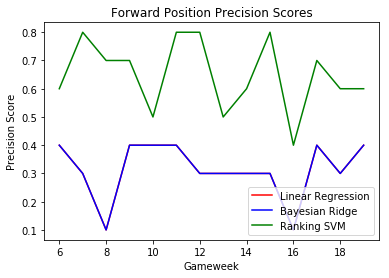

In [826]:
import matplotlib.pyplot as plt

gw = range(6,20)


plt.plot(gw, lin.values(), 'r', label='Linear Regression')
plt.plot(gw, bayes_ridge.values(), 'b', label='Bayesian Ridge')  
plt.plot(gw, svm_rank.values(), 'g', label='Ranking SVM') 
plt.ylabel('Precision Score')
plt.xlabel('Gameweek')
plt.legend(loc='lower right')
plt.title('Forward Position Precision Scores')
plt.show()
plt.savefig('forward_precision.png')

# Defender:

In [827]:

lin, svr, bayes_ridge, svm_rank = get_defender_results(def_features)

print lin
print bayes_ridge
print svm_rank

# def_neural_precision = neural_network(X_train_players_def_avg_df, Y_train_players_def_avg_df, 
#                                   X_test_players_def_gw_df, Y_test_players_def_gw_df)

# print "Neural Networks: ", def_neural_precision


{6: 0.1, 7: 0.2, 8: 0.1, 9: 0.2, 10: 0.1, 11: 0.1, 12: 0.3, 13: 0.0, 14: 0.1, 15: 0.0, 16: 0.1, 17: 0.2, 18: 0.4, 19: 0.0}
{6: 0.1, 7: 0.2, 8: 0.1, 9: 0.2, 10: 0.1, 11: 0.1, 12: 0.3, 13: 0.0, 14: 0.1, 15: 0.0, 16: 0.1, 17: 0.2, 18: 0.4, 19: 0.0}
{6: 0.3, 7: 0.4, 8: 0.6, 9: 0.7, 10: 0.5, 11: 0.7, 12: 0.4, 13: 0.5, 14: 0.5, 15: 0.3, 16: 0.5, 17: 0.2, 18: 0.2, 19: 0.7}


In [828]:
lin, svr, bayes_ridge, svm_rank = get_defender_results(def_features + def_implicit_features + past_history_features)

print lin
print bayes_ridge
print svm_rank

{6: 0.2, 7: 0.3, 8: 0.1, 9: 0.1, 10: 0.1, 11: 0.1, 12: 0.1, 13: 0.0, 14: 0.2, 15: 0.1, 16: 0.0, 17: 0.2, 18: 0.2, 19: 0.1}
{6: 0.1, 7: 0.2, 8: 0.1, 9: 0.1, 10: 0.1, 11: 0.1, 12: 0.1, 13: 0.0, 14: 0.1, 15: 0.1, 16: 0.0, 17: 0.2, 18: 0.2, 19: 0.1}
{6: 0.5, 7: 0.6, 8: 0.5, 9: 0.7, 10: 0.6, 11: 0.7, 12: 0.5, 13: 0.4, 14: 0.5, 15: 0.5, 16: 0.6, 17: 0.1, 18: 0.3, 19: 0.7}


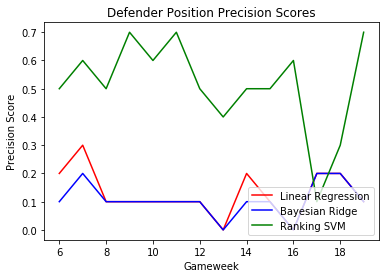

In [829]:
plt.plot(gw, lin.values(), 'r', label='Linear Regression')
plt.plot(gw, bayes_ridge.values(), 'b', label='Bayesian Ridge')  
plt.plot(gw, svm_rank.values(), 'g', label='Ranking SVM') 
plt.ylabel('Precision Score')
plt.xlabel('Gameweek')
plt.legend(loc='lower right')
plt.title('Defender Position Precision Scores')
plt.show()
plt.savefig('defender_precision.png')

In [830]:
lin, svr, bayes_ridge, svm_rank = get_defender_results(def_features + def_implicit_features)

print lin
print bayes_ridge
print svm_rank

{6: 0.1, 7: 0.3, 8: 0.1, 9: 0.1, 10: 0.1, 11: 0.1, 12: 0.1, 13: 0.0, 14: 0.1, 15: 0.1, 16: 0.0, 17: 0.2, 18: 0.2, 19: 0.1}
{6: 0.1, 7: 0.2, 8: 0.1, 9: 0.1, 10: 0.1, 11: 0.1, 12: 0.1, 13: 0.0, 14: 0.1, 15: 0.1, 16: 0.0, 17: 0.2, 18: 0.2, 19: 0.1}
{6: 0.5, 7: 0.6, 8: 0.5, 9: 0.7, 10: 0.7, 11: 0.7, 12: 0.5, 13: 0.4, 14: 0.5, 15: 0.4, 16: 0.6, 17: 0.1, 18: 0.4, 19: 0.7}


In [766]:
lin, svr, bayes_ridge, svm_rank = get_defender_results(def_features + past_history_features)

print lin
print bayes_ridge
print svm_rank

/home/bhargava/anaconda2/envs/cs670/lib/python2.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


{6: 0.1, 7: 0.2, 8: 0.1, 9: 0.2, 10: 0.1, 11: 0.2, 12: 0.3, 13: 0.0, 14: 0.1, 15: 0.0, 16: 0.1, 17: 0.2, 18: 0.4, 19: 0.0}
{6: 0.1, 7: 0.2, 8: 0.1, 9: 0.2, 10: 0.1, 11: 0.1, 12: 0.2, 13: 0.0, 14: 0.1, 15: 0.0, 16: 0.1, 17: 0.2, 18: 0.4, 19: 0.0}
{6: 0.4, 7: 0.4, 8: 0.6, 9: 0.7, 10: 0.6, 11: 0.6, 12: 0.4, 13: 0.6, 14: 0.5, 15: 0.4, 16: 0.5, 17: 0.2, 18: 0.2, 19: 0.6}


# Goalkeeper:

In [831]:
lin, svr, bayes_ridge, svm_rank = get_goalkeeper_results(glk_features)

print lin

print bayes_ridge
print svm_rank

{6: 0.5, 7: 0.5, 8: 0.5, 9: 0.4, 10: 0.4, 11: 0.6, 12: 0.5, 13: 0.6, 14: 0.3, 15: 0.2, 16: 0.6, 17: 0.4, 18: 0.5, 19: 0.5}
{6: 0.5, 7: 0.5, 8: 0.5, 9: 0.4, 10: 0.4, 11: 0.6, 12: 0.5, 13: 0.6, 14: 0.3, 15: 0.2, 16: 0.6, 17: 0.4, 18: 0.5, 19: 0.5}
{6: 0.6, 7: 0.2, 8: 0.6, 9: 0.7, 10: 0.8, 11: 0.7, 12: 0.6, 13: 0.8, 14: 0.6, 15: 0.6, 16: 0.7, 17: 0.7, 18: 0.5, 19: 0.6}


In [835]:
lin, svr, bayes_ridge, svm_rank = get_goalkeeper_results(glk_features + past_history_features)

print lin

print bayes_ridge
print svm_rank

{6: 0.5, 7: 0.5, 8: 0.5, 9: 0.4, 10: 0.4, 11: 0.6, 12: 0.5, 13: 0.6, 14: 0.3, 15: 0.2, 16: 0.6, 17: 0.4, 18: 0.5, 19: 0.5}
{6: 0.5, 7: 0.5, 8: 0.5, 9: 0.4, 10: 0.4, 11: 0.6, 12: 0.5, 13: 0.6, 14: 0.3, 15: 0.2, 16: 0.6, 17: 0.4, 18: 0.5, 19: 0.5}
{6: 0.7, 7: 0.2, 8: 0.6, 9: 0.7, 10: 0.8, 11: 0.8, 12: 0.6, 13: 0.7, 14: 0.6, 15: 0.7, 16: 0.7, 17: 0.8, 18: 0.6, 19: 0.6}


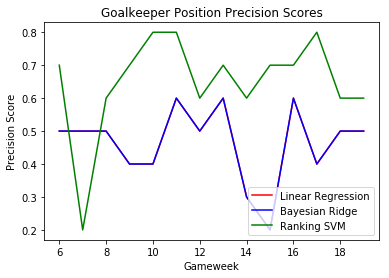

In [836]:
plt.plot(gw, lin.values(), 'r', label='Linear Regression')
plt.plot(gw, bayes_ridge.values(), 'b', label='Bayesian Ridge')  
plt.plot(gw, svm_rank.values(), 'g', label='Ranking SVM') 
plt.ylabel('Precision Score')
plt.xlabel('Gameweek')
plt.legend(loc='lower right')
plt.title('Goalkeeper Position Precision Scores')
plt.show()
plt.savefig('goalkeeper_precision_1.png')

In [833]:
lin, svr, bayes_ridge, svm_rank = get_goalkeeper_results(glk_features + past_history_features + implicit_features)

print lin

print bayes_ridge
print svm_rank

{6: 0.4, 7: 0.5, 8: 0.5, 9: 0.5, 10: 0.4, 11: 0.6, 12: 0.6, 13: 0.6, 14: 0.4, 15: 0.2, 16: 0.6, 17: 0.4, 18: 0.5, 19: 0.4}
{6: 0.4, 7: 0.5, 8: 0.5, 9: 0.5, 10: 0.4, 11: 0.6, 12: 0.6, 13: 0.6, 14: 0.4, 15: 0.2, 16: 0.6, 17: 0.4, 18: 0.5, 19: 0.4}
{6: 0.6, 7: 0.3, 8: 0.6, 9: 0.6, 10: 0.8, 11: 0.8, 12: 0.5, 13: 0.8, 14: 0.6, 15: 0.7, 16: 0.7, 17: 0.6, 18: 0.5, 19: 0.6}


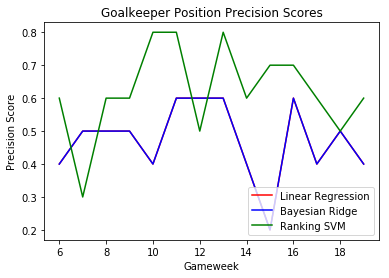

In [834]:
plt.plot(gw, lin.values(), 'r', label='Linear Regression')
plt.plot(gw, bayes_ridge.values(), 'b', label='Bayesian Ridge')  
plt.plot(gw, svm_rank.values(), 'g', label='Ranking SVM') 
plt.ylabel('Precision Score')
plt.xlabel('Gameweek')
plt.legend(loc='lower right')
plt.title('Goalkeeper Position Precision Scores')
plt.show()
plt.savefig('goalkeeper_precision.png')

# Midfielder:

In [837]:
lin, svr, bayes_ridge, svm_rank = get_midfielder_results(mid_features)

print lin
print bayes_ridge
print svm_rank


{6: 0.3, 7: 0.1, 8: 0.3, 9: 0.1, 10: 0.1, 11: 0.3, 12: 0.2, 13: 0.2, 14: 0.4, 15: 0.2, 16: 0.1, 17: 0.1, 18: 0.3, 19: 0.2}
{6: 0.3, 7: 0.1, 8: 0.3, 9: 0.1, 10: 0.1, 11: 0.3, 12: 0.2, 13: 0.2, 14: 0.4, 15: 0.2, 16: 0.1, 17: 0.1, 18: 0.3, 19: 0.2}
{6: 0.5, 7: 0.4, 8: 0.3, 9: 0.1, 10: 0.2, 11: 0.6, 12: 0.3, 13: 0.5, 14: 0.4, 15: 0.5, 16: 0.3, 17: 0.4, 18: 0.6, 19: 0.6}


In [838]:
lin, svr, bayes_ridge, svm_rank = get_midfielder_results(mid_features + mid_implicit_features)

print lin
print bayes_ridge
print svm_rank


{6: 0.3, 7: 0.0, 8: 0.3, 9: 0.1, 10: 0.1, 11: 0.3, 12: 0.2, 13: 0.1, 14: 0.3, 15: 0.2, 16: 0.1, 17: 0.2, 18: 0.3, 19: 0.2}
{6: 0.3, 7: 0.0, 8: 0.3, 9: 0.1, 10: 0.1, 11: 0.3, 12: 0.2, 13: 0.1, 14: 0.3, 15: 0.2, 16: 0.1, 17: 0.2, 18: 0.3, 19: 0.2}
{6: 0.5, 7: 0.6, 8: 0.4, 9: 0.2, 10: 0.2, 11: 0.6, 12: 0.4, 13: 0.5, 14: 0.4, 15: 0.6, 16: 0.3, 17: 0.4, 18: 0.5, 19: 0.6}


In [839]:
lin, svr, bayes_ridge, svm_rank = get_midfielder_results(mid_features + mid_implicit_features + past_history_features)

print lin
print bayes_ridge
print svm_rank

{6: 0.3, 7: 0.0, 8: 0.3, 9: 0.1, 10: 0.1, 11: 0.3, 12: 0.2, 13: 0.1, 14: 0.3, 15: 0.2, 16: 0.1, 17: 0.2, 18: 0.3, 19: 0.2}
{6: 0.3, 7: 0.0, 8: 0.3, 9: 0.1, 10: 0.1, 11: 0.3, 12: 0.2, 13: 0.1, 14: 0.3, 15: 0.2, 16: 0.1, 17: 0.2, 18: 0.3, 19: 0.2}
{6: 0.5, 7: 0.6, 8: 0.4, 9: 0.2, 10: 0.3, 11: 0.6, 12: 0.4, 13: 0.5, 14: 0.3, 15: 0.6, 16: 0.3, 17: 0.4, 18: 0.5, 19: 0.6}


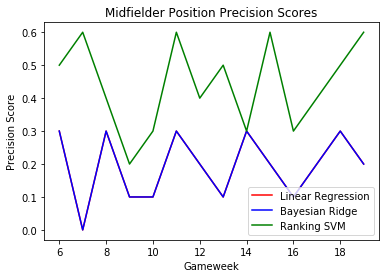

In [840]:
plt.plot(gw, lin.values(), 'r', label='Linear Regression')
plt.plot(gw, bayes_ridge.values(), 'b', label='Bayesian Ridge')  
plt.plot(gw, svm_rank.values(), 'g', label='Ranking SVM') 
plt.ylabel('Precision Score')
plt.xlabel('Gameweek')
plt.legend(loc='lower right')
plt.title('Midfielder Position Precision Scores')
plt.show()
plt.savefig('midfielder_precision.png')

# Form Team

In [83]:
#player_cost_df = pd.read_csv('data/player_cost.csv')

#Reference : http://www.philipkalinda.com/ds9.html



In [99]:
from pulp import *
prob = pulp.LpProblem('FantasyTeam', pulp.LpMaximize)


In [100]:
decision_variables = []
for rownum, row in player_cost_df.iterrows():
    variable = str('x' + str(rownum))
    variable = pulp.LpVariable(str(variable), lowBound = 0, upBound = 1, cat= 'Integer') #make variables binary
    decision_variables.append(variable)

print ("Total number of decision_variables: " + str(len(decision_variables)))


Total number of decision_variables: 16


In [101]:
total_points = ""
for rownum, row in player_cost_df.iterrows():
    for i, player in enumerate(decision_variables):
        if rownum == i:
            formula = row['Cost']*player
            total_points += formula

prob += total_points
print ("Optimization function: " + str(total_points))

Optimization function: 6*x0 + 7*x1 + 5*x10 + 6*x11 + 5*x12 + 6*x13 + 5*x14 + 4*x15 + 4*x2 + 5*x3 + 6*x4 + 7*x5 + 5*x6 + 6*x7 + 3*x8 + 4*x9


In [102]:
avail_cash = 30
total_paid = ""
for rownum, row in player_cost_df.iterrows():
    for i, player in enumerate(decision_variables):
        if rownum == i:
            formula = row['Cost']*player
            total_paid += formula

prob += (total_paid <= avail_cash)

print prob

FantasyTeam:
MAXIMIZE
6*x0 + 7*x1 + 5*x10 + 6*x11 + 5*x12 + 6*x13 + 5*x14 + 4*x15 + 4*x2 + 5*x3 + 6*x4 + 7*x5 + 5*x6 + 6*x7 + 3*x8 + 4*x9 + 0
SUBJECT TO
_C1: 6 x0 + 7 x1 + 5 x10 + 6 x11 + 5 x12 + 6 x13 + 5 x14 + 4 x15 + 4 x2 + 5 x3
 + 6 x4 + 7 x5 + 5 x6 + 6 x7 + 3 x8 + 4 x9 <= 30

VARIABLES
0 <= x0 <= 1 Integer
0 <= x1 <= 1 Integer
0 <= x10 <= 1 Integer
0 <= x11 <= 1 Integer
0 <= x12 <= 1 Integer
0 <= x13 <= 1 Integer
0 <= x14 <= 1 Integer
0 <= x15 <= 1 Integer
0 <= x2 <= 1 Integer
0 <= x3 <= 1 Integer
0 <= x4 <= 1 Integer
0 <= x5 <= 1 Integer
0 <= x6 <= 1 Integer
0 <= x7 <= 1 Integer
0 <= x8 <= 1 Integer
0 <= x9 <= 1 Integer



In [103]:
avail_gk = 1
total_gk = ""
for rownum, row in player_cost_df.iterrows():
    for i, player in enumerate(decision_variables):
        if rownum == i:
            if row['Position'] == 'GLK':
                formula = 1*player
                total_gk += formula
prob += (total_gk == avail_gk)
print(total_gk)

x14 + x15


In [104]:
print total_gk

x14 + x15


In [105]:
avail_def = 2
total_def = ""
for rownum, row in player_cost_df.iterrows():
    for i, player in enumerate(decision_variables):
        if rownum == i:
            if row['Position'] == 'DEF':
                formula = 1*player
                total_def += formula
prob += (total_def == avail_def)
print((total_def))

x0 + x2 + x3 + x4 + x5 + x6 + x7


In [91]:
# avail_mid = 4
# total_mid = ""
# for rownum, row in pdata.iterrows():
#     for i, player in enumerate(decision_variables):
#         if rownum == i:
#             if row['element_type_name'] == 'MID':
#                 formula = 1*player
#                 total_mid += formula
# prob += (total_mid == avail_mid)
# print((total_mid))

In [106]:
avail_fwd = 2
total_fwd = ""
for rownum, row in player_cost_df.iterrows():
    for i, player in enumerate(decision_variables):
        if rownum == i:
            if row['Position'] == 'FWD':
                formula = 1*player
                total_fwd += formula
prob += (total_fwd == avail_fwd)
print(total_fwd)

x1 + x10 + x11 + x12 + x13 + x8 + x9


In [107]:
team_dict= {}
for team in set(player_cost_df['Team']):
    team_dict[str(team)]=dict()
    team_dict[str(team)]['avail'] = 3
    team_dict[str(team)]['total'] = ""
    for rownum, row in player_cost_df.iterrows():
        for i, player in enumerate(decision_variables):
            if rownum == i:
                if row['Team'] == team:
                    formula = 1*player
                    team_dict[str(team)]['total'] += formula

    prob += (team_dict[str(team)]['total'] <= team_dict[str(team)]['avail'])
print(len(team_dict))

2


In [108]:
print prob

FantasyTeam:
MAXIMIZE
6*x0 + 7*x1 + 5*x10 + 6*x11 + 5*x12 + 6*x13 + 5*x14 + 4*x15 + 4*x2 + 5*x3 + 6*x4 + 7*x5 + 5*x6 + 6*x7 + 3*x8 + 4*x9 + 0
SUBJECT TO
_C1: 6 x0 + 7 x1 + 5 x10 + 6 x11 + 5 x12 + 6 x13 + 5 x14 + 4 x15 + 4 x2 + 5 x3
 + 6 x4 + 7 x5 + 5 x6 + 6 x7 + 3 x8 + 4 x9 <= 30

_C2: x14 + x15 = 1

_C3: x0 + x2 + x3 + x4 + x5 + x6 + x7 = 2

_C4: x1 + x10 + x11 + x12 + x13 + x8 + x9 = 2

_C5: x1 + x11 + x12 + x13 + x15 + x4 + x5 <= 3

_C6: x0 + x10 + x14 + x2 + x3 + x6 + x7 + x8 + x9 <= 3

VARIABLES
0 <= x0 <= 1 Integer
0 <= x1 <= 1 Integer
0 <= x10 <= 1 Integer
0 <= x11 <= 1 Integer
0 <= x12 <= 1 Integer
0 <= x13 <= 1 Integer
0 <= x14 <= 1 Integer
0 <= x15 <= 1 Integer
0 <= x2 <= 1 Integer
0 <= x3 <= 1 Integer
0 <= x4 <= 1 Integer
0 <= x5 <= 1 Integer
0 <= x6 <= 1 Integer
0 <= x7 <= 1 Integer
0 <= x8 <= 1 Integer
0 <= x9 <= 1 Integer



In [109]:
prob.writeLP('FantasyTeam.lp')
optimization_result = prob.solve()
assert optimization_result == pulp.LpStatusOptimal
print("Status:", LpStatus[prob.status])
print("Optimal Solution to the problem: ", value(prob.objective))
print ("Individual decision_variables: ")
for v in prob.variables():
    print(v.name, "=", v.varValue)

('Status:', 'Optimal')
('Optimal Solution to the problem: ', 30.0)
Individual decision_variables: 
('x0', '=', 1.0)
('x1', '=', 1.0)
('x10', '=', 0.0)
('x11', '=', 1.0)
('x12', '=', 0.0)
('x13', '=', 0.0)
('x14', '=', 1.0)
('x15', '=', 0.0)
('x2', '=', 0.0)
('x3', '=', 0.0)
('x4', '=', 1.0)
('x5', '=', 0.0)
('x6', '=', 0.0)
('x7', '=', 0.0)
('x8', '=', 0.0)
('x9', '=', 0.0)


In [117]:
import re

variable_name = []
variable_value = []

for v in prob.variables():
    variable_name.append(v.name)
    variable_value.append(v.varValue)

df = pd.DataFrame({'variable': variable_name, 'value': variable_value})
for rownum, row in df.iterrows():
    value = re.findall(r'(\d+)', row['variable'])
    df.loc[rownum, 'variable'] = int(value[0])

df = df.sort_values(by='variable')

#append results
for rownum, row in player_cost_df.iterrows():
    for results_rownum, results_row in df.iterrows():
        if rownum == results_row['variable']:
            player_cost_df.loc[rownum, 'decision'] = results_row['value']

            
print player_cost_df
# player_cost_df[player_cost_df['decision']==1].now_cost.sum() # Returns 830
# player_cost_df[player_cost_df['decision']==1].total_points.sum() # Returns 2010.8606251232461
player_cost_df[player_cost_df['decision']==1].sort_values('Cost', ascending=False).head(5)

   Player Position  Cost Team  decision
0       A      DEF     6  ARS       1.0
1       B      FWD     7  MUN       1.0
2       C      DEF     4  ARS       0.0
3       D      DEF     5  ARS       0.0
4       E      DEF     6  MUN       1.0
5       F      DEF     7  MUN       0.0
6       G      DEF     5  ARS       0.0
7       H      DEF     6  ARS       0.0
8       I      FWD     3  ARS       0.0
9       J      FWD     4  ARS       0.0
10      K      FWD     5  ARS       0.0
11      L      FWD     6  MUN       1.0
12      M      FWD     5  MUN       0.0
13      N      FWD     6  MUN       0.0
14      O      GLK     5  ARS       1.0
15      P      GLK     4  MUN       0.0


,Player,Position,Cost,Team,decision
1,B,FWD,7,MUN,1.0
0,A,DEF,6,ARS,1.0
4,E,DEF,6,MUN,1.0
11,L,FWD,6,MUN,1.0
14,O,GLK,5,ARS,1.0
